# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [34]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, explode, concat, lit, min, max
from pyspark.sql.functions import sum as Fsum
import seaborn as sns 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC,NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt



In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Data Exploratory") \
    .getOrCreate()

In [4]:
#Check session
spark.sparkContext.getConf().getAll()
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# load dataset 
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
#write csv
#out_path = "data/sparkify_mini.csv"
#user_log.write.save(out_path, format="csv", header=True)
#user_log_2 = spark.read.csv(out_path, header=True)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
#select(): returns a new DataFrame with the selected columns
user_log.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [7]:
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
user_log.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
user_log.describe().show()


+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [10]:
# Drop Rows with Missing Values
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [11]:
#Drop userID values that are empty strings
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [12]:
user_log_valid.count()

278154

In [13]:
#Define Churn
#create a column Churn to use as the label 
#I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. 
flag_Cancellation_Confirmation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [14]:
user_log_valid = user_log_valid.withColumn("churn", flag_Cancellation_Confirmation_event("page"))

In [15]:
from pyspark.sql import Window
user_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

df_churn=user_log_valid.withColumn('churn', Fsum('churn').over(user_window))

In [16]:
df_churn.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0)

In [17]:
df_churn.dropDuplicates(['userId']).select('churn').groupby('churn').count().collect()


[Row(churn=0, count=173), Row(churn=1, count=52)]

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     M|   32|
|    1|     F|   20|
+-----+------+-----+



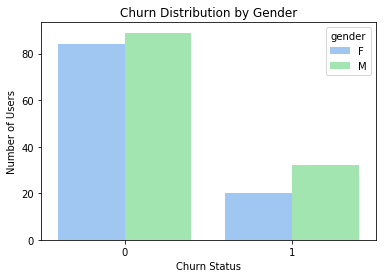

In [18]:
# plot churn by gender
pdf = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x = 'churn', y='count', palette='pastel', hue = 'gender', data=pdf)
plt.title("Churn Distribution by Gender")
plt.xlabel('Churn Status')
plt.ylabel('Number of Users')
df_churn.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort("churn").show()
plt.savefig('plot_churnbygender.png')

,level,count
0,free,21
1,paid,31


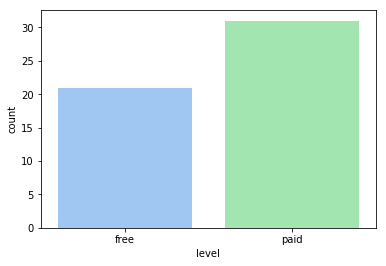

In [19]:
# plot churn by free or paid
df_level = df_churn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(x = 'level', y = 'count', palette='pastel', data = df_level)
df_churn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

##### The Explotary Data Analysis on account level shows that paid users churn approximately %20 more than free users. This may be bacuse of the subscription payment compared to other alternative music apps. This inference is also supported by the fact that there is still quite a number of free users who churn.


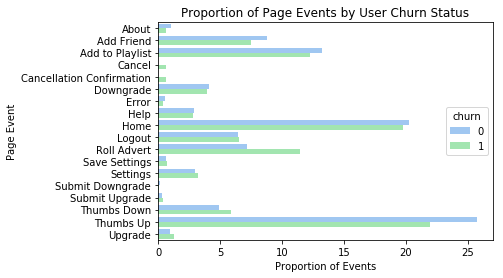

In [20]:
# plot churn by page event
df_page_event = df_churn.groupby(['page','churn']).count().toPandas()
df_page_event = df_page_event[df_page_event['page'] != 'NextSong']
df_page_event = ((df_page_event.groupby(['page','churn']).sum() / df_page_event.groupby(['churn']).sum()) *100).reset_index()
sns.barplot(y = 'page', x = 'count', palette='pastel', data = df_page_event, hue = 'churn')
plt.title("Proportion of Page Events by User Churn Status")
plt.ylabel('Page Event')
plt.xlabel('Proportion of Events')
plt.savefig('plot_ProportionPageEventsbyUserChurnStatus.png')

#### The change of churn status from 0 to 1 according to the proportion of the page events is highest  after Roll Advert! It shows that users usually churn after roll advertising.  The second highest is the Thumbs down. This can be due to users disliking the music that they listen to.

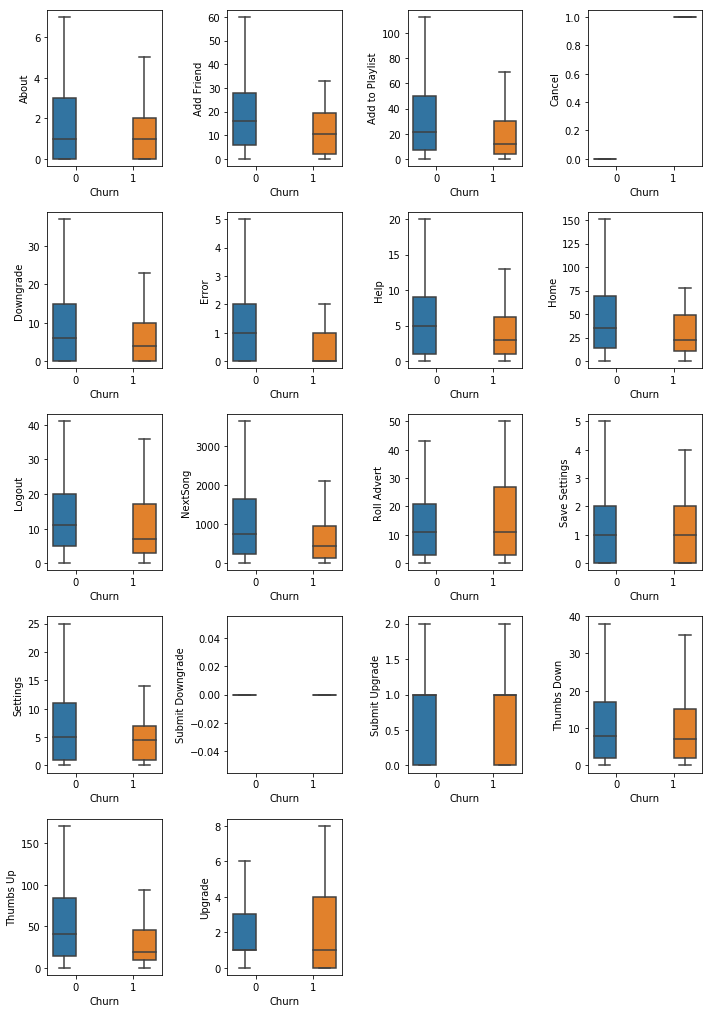

In [21]:
events_pivot = df_churn.groupby(["userId"]).pivot("page").count().fillna(0)
events_pivot = events_pivot.toPandas()
events_pivot.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)
plot_columns = events_pivot.drop('Churn', axis = 1).columns
fig = plt.figure(figsize=(10, 18))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    k=sns.boxplot(x='Churn',y=plot_columns[i],hue='Churn', showfliers=False,data=events_pivot)
    l = plt.legend([],[], frameon=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("featureschurn.png")


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
df_churn_sql = df_churn.createOrReplaceTempView("feature_table")

In [23]:
df_feature = spark.sql(
    '''
          SELECT DISTINCT 
          userId,  
          (CASE WHEN gender = 'M' THEN 0 ELSE 1 END) AS gender,
          (CASE WHEN level = 'free' THEN 0 ELSE 1 END) AS level,
          SUM(CASE WHEN page = 'Home' THEN 1 ELSE 0 END) AS is_home,
          SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS sum_add_playlist,
          SUM(CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END) AS downgrade_count,
          SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS error_count,
          SUM(CASE WHEN page = 'Help' THEN 1 ELSE 0 END) AS help_count,
          SUM(CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END) AS roll_advert_count,
          SUM(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END) AS submit_downgrade_count,
          SUM(CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END) AS submit_upgrade_count,
          SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS thumbs_down_count,
          SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS thumbs_up_count,
          SUM(CASE WHEN page = 'Upgrade' THEN 1 ELSE 0 END) AS upgrade_count,
          COUNT(DISTINCT song) AS total_songs,
          COUNT(DISTINCT sessionId) AS total_sessions,
          MAX(ts - registration) AS account_lifetime,
          churn
          FROM feature_table
          GROUP BY userId,churn,gender,level
    ''')

df_final = df_feature.toPandas()
df_final.head()

,userId,gender,level,is_home,sum_add_playlist,downgrade_count,error_count,help_count,roll_advert_count,submit_downgrade_count,submit_upgrade_count,thumbs_down_count,thumbs_up_count,upgrade_count,total_songs,total_sessions,account_lifetime,churn
0,100023,0,0,1,1,0,0,0,3,0,1,0,2,1,26,2,2094885000,1
1,84,1,0,4,2,0,0,1,10,0,0,0,4,0,71,3,4533248000,0
2,100008,1,0,4,0,0,0,0,9,0,0,0,1,4,51,2,5894948000,0
3,100009,0,1,9,7,5,0,2,1,1,0,1,7,0,275,4,2750266000,1
4,100018,0,0,16,7,0,0,4,76,0,2,5,20,4,409,6,9565527000,0


,churn,total_songs_counts
0,0,171745
1,1,33719


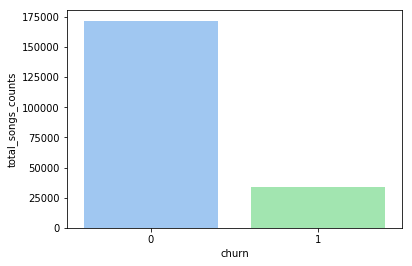

In [24]:
# plot churn by total songs played
total_songs =  df_final.groupby(['churn'])['total_songs'].sum().reset_index(name='total_songs_counts')
total_sessions =  df_final.groupby(['churn'])['total_sessions'].sum().reset_index(name='total_sessions_counts')
account_lifetime =  df_final.groupby(['churn'])['account_lifetime'].sum().reset_index(name='account_lifetime_counts')

sns.barplot(x='churn',y='total_songs_counts', palette='pastel', data=total_songs)
total_songs


,churn,total_sessions_counts
0,0,2809
1,1,577


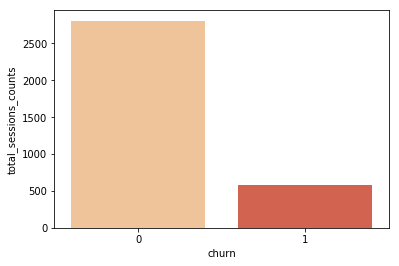

In [25]:
# plot churn by total sessions 
sns.barplot(x='churn',y='total_sessions_counts', palette='OrRd', data=total_sessions)
total_sessions

,churn,account_lifetime_counts
0,0,1869384206000
1,1,379737577000


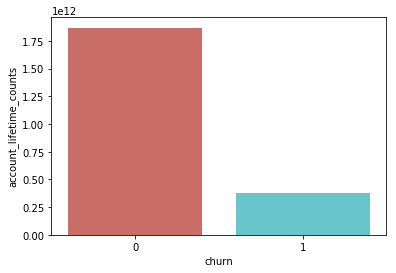

In [26]:
# plot churn by total account lifetime 

sns.barplot(x='churn',y='account_lifetime_counts', palette='hls', data=account_lifetime)
account_lifetime 

##### From the above analysis, it can be clearly seen that non churned users have longer playing time, than churned users by 5-folds ( total songs played and total sessions). The following factors are also important features to use in the model for user churn.

* Total sessions - Non-churned users have ~ 5 times more sessions than churned users
* Total songs - Non-churned users are listening ~ 5 times more songs than churned users
* Total account lifetime - Non-churned users have more account lifetime 
* Add Friends - Churned users are less likely to add friends
* Add to Playlist - Churned users are less likely to add to playlists
* Upgrade - Churned users have a wide range of upgrade activities
* NextSong - Churned users are less likely to play next song
* ThumbsUp - Churned users are less likely to press thumbs up
* Roll Advert - Churned users have a wider spread on roll advert
* Settings - Churned users less likely to visit settings page
* Log out - Churned users less likely to log out (due to less logins)
* Help - Non-churned users more likely to ask for help
* Home - Churned users less likely to visit home page (due to less logins)

Other columns are not taken into feature dataframe: First Name,Last Name, authm,status,gender, ItemInSession,location,method,artist

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [28]:
# Create vector from feature data
feature_names = df_feature.columns[1:-1]

assembler = VectorAssembler(inputCols=feature_names, outputCol="FeatureVector")
df_feature_vectored = assembler.transform(df_feature)
# Scale each column
scaler = StandardScaler(inputCol="FeatureVector", outputCol="features")
#fit the model 
df_scaled = scaler.fit(df_feature_vectored)
df_scaled = df_scaled.transform(df_feature_vectored)


In [29]:
df_final = df_scaled.select(['features', df_scaled['churn'].alias('label')])
df_final.head()

Row(features=SparseVector(16, {2: 0.0286, 3: 0.0387, 7: 0.1658, 9: 1.4851, 11: 0.0384, 12: 0.4368, 13: 0.0359, 14: 0.1952, 15: 0.6168}), label=1)

In [30]:
train, test = df_final.randomSplit([0.8, 0.2], seed=42)


In [31]:
def train_models(model, train, test):
    '''
    This function trains the model and make prediction with measuring f1 score.
    
    :param model: classification model 
    :param train: training data
    :param test: test data
    '''
    classifier=model.fit(train)
    pred = classifier.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
    f1score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    acc = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    prc = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    rec = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    print('Model:{}'.format(model))
    print('F1 Score:{}'.format(f1score))
    print('accuracy:', acc)
    print('precision:', prc)
    print ('conf matrix:', pred.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())


In [40]:

# Logistic Regression
lr = LogisticRegression(featuresCol ='features', labelCol = 'label',maxIter=10, regParam=0.01)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol ='features', labelCol = 'label',numTrees=50,seed=42,featureSubsetStrategy='sqrt')

# GBT Classifier
gbt = GBTClassifier(featuresCol ='features', labelCol = 'label')

#Linear SVC 
svm = LinearSVC(featuresCol ='features', labelCol = 'label')

# classificaton models
ClassModels=[lr,rf,gbt,svm]

In [33]:
for i in ClassModels:
    train_models(i,train,test)

Model:LogisticRegression_e84449e4493b
F1 Score:0.6539540777841475
accuracy: 0.7272727272727273
precision: 0.6292029887920298
conf matrix:    label  0.0  1.0
0      0   55    3
1      1   18    1
Model:RandomForestClassifier_f9267537c132
F1 Score:0.7136683672116744
accuracy: 0.7532467532467533
precision: 0.7128740824392998
conf matrix:    label  0.0  1.0
0      0   54    4
1      1   15    4
Model:GBTClassifier_c5bf4be2a48d
F1 Score:0.6363636363636364
accuracy: 0.6363636363636364
precision: 0.6363636363636364
conf matrix:    label  0.0  1.0
0      0   44   14
1      1   14    5
Model:LinearSVC_c5d37b4ddb12
F1 Score:0.6472342472342472
accuracy: 0.7532467532467533
precision: 0.5673806712767753
conf matrix:    label  0.0
0      0   58
1      1   19


##### The RandomForest model showed the best performance (F1 Score) in the test set. F1 score is defined as the harmonic mean of precision and recall where precision is computing the proportion of positive class identifications being the correct ones and Recall is computing the proportion of actual positive class samples being identified correctly.
#### Since there is a small portion of churn users, to correctly identify this class F1 score is osed as metrics  instead of pursuing a high overall performance. When there is a population with 5% churn rate (true population) then predicting all population as non-churn will give still high accuracy with 95%. To penalize this in our evaluation F1 score is used.

In [44]:
#Tune best model

# Crossvalidator and parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth,[2, 5, 20]) \
    .addGrid(rf.maxBins,[10, 20]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)


In [ ]:
cv = crossval.fit(train)
prediction = cv.transform(test)

In [ ]:
bestmodel_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
bestmodel_f1score = bestmodel_evaluator.evaluate(prediction, {bestmodel_evaluator.metricName: "f1"})
print('F-1 Score with tuned parameters:{})'.format(bestmodel_f1score))


Tuning of the parameters have not improved the score due to the size limitation of the dataset.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify_Data_Scientist_Capstone_Project.ipynb'])